In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import warnings

warnings.filterwarnings("ignore")

In [20]:
# Гіперпараметри
z_dim = 100
lr = 0.0002
batch_size = 128
num_epochs = 107
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# Генератор
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            nn.Linear(self.z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 784),
            nn.Tanh()
        )
        
    def forward(self, noise):
        return self.gen(noise)

In [22]:
# Дискримінатор
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, image):
        return self.disc(image)

In [23]:
# Завантаження даних
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)

100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 8262700.54it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 6961021.37it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 5176635.16it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|███████████████████████████████████| 4542/4542 [00:00<00:00, 271781.56it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [24]:
# Ініціалізація моделей та оптимізаторів
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

In [25]:
# Навчання моделі
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(data_loader):
        real_images = real_images.view(-1, 784).to(device)
        batch_size = real_images.shape[0]
        
        # Мітки для реальних та фейкових зображень
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Навчання дискримінатора
        d_optimizer.zero_grad()
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        
        noise = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        # Навчання генератора
        g_optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
    # Вивід прогресу
    print(f"Епоха [{epoch+1}/{num_epochs}], D Втрати: {d_loss:.4f}, G Втрати: {g_loss:.4f}")

Епоха [1/107], D Втрати: 0.8725, G Втрати: 0.8805
Епоха [2/107], D Втрати: 0.5977, G Втрати: 1.3719
Епоха [3/107], D Втрати: 1.3876, G Втрати: 0.7055
Епоха [4/107], D Втрати: 1.0304, G Втрати: 0.9669
Епоха [5/107], D Втрати: 0.7606, G Втрати: 1.3026
Епоха [6/107], D Втрати: 0.9688, G Втрати: 1.1554
Епоха [7/107], D Втрати: 0.8154, G Втрати: 1.2678
Епоха [8/107], D Втрати: 1.0055, G Втрати: 1.0969
Епоха [9/107], D Втрати: 1.2190, G Втрати: 0.9655
Епоха [10/107], D Втрати: 1.3662, G Втрати: 0.7165
Епоха [11/107], D Втрати: 0.9909, G Втрати: 1.2327
Епоха [12/107], D Втрати: 1.1053, G Втрати: 1.1081
Епоха [13/107], D Втрати: 1.1550, G Втрати: 1.0065
Епоха [14/107], D Втрати: 1.0890, G Втрати: 1.2977
Епоха [15/107], D Втрати: 1.0859, G Втрати: 1.2073
Епоха [16/107], D Втрати: 1.0347, G Втрати: 1.2014
Епоха [17/107], D Втрати: 0.5307, G Втрати: 1.8836
Епоха [18/107], D Втрати: 1.2272, G Втрати: 1.1488
Епоха [19/107], D Втрати: 0.9060, G Втрати: 1.2018
Епоха [20/107], D Втрати: 1.1898, G Втра

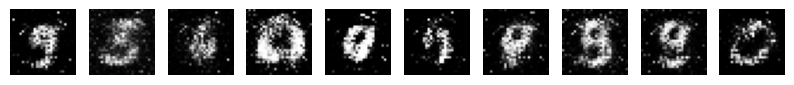

In [26]:
# Генерація та відображення зображень
z = torch.randn(10, z_dim).to(device)
generated_images = generator(z)

fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axes[i].imshow(generated_images[i].cpu().detach().view(28, 28), cmap='gray')  # Додайте .cpu() для переносу на CPU
    axes[i].axis('off')
plt.show()